In [15]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os

# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 18 * 18, 128)  # Assuming image size 150x150
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 18 * 18)  # Flatten the output from convolutional layers
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Image transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [16]:
# Define the path to your dataset
train_path = r'/Users/marienel18/Documents/ECDS-NeuralNets-main/Day 3/Datasets/Eggs Classification'  # Use raw string to avoid escape characters

# Load the full dataset using ImageFolder
full_dataset = datasets.ImageFolder(train_path, transform=transform)

# Split into training (80%) and validation (20%)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create DataLoader objects to load the data in batches
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [17]:
# Initialize the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
# Function to train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    train_loss = []
    train_accuracy = []

    for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            predicted = (outputs.squeeze() > 0.5).float()  # Apply threshold of 0.5
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        accuracy = correct / total * 100
        train_loss.append(epoch_loss)
        train_accuracy.append(accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

    return train_loss, train_accuracy

In [19]:
# Function to validate the model
def validate_model(model, val_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels.float())
            running_loss += loss.item()

            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(val_loader)
    accuracy = correct / total * 100
    print(f"validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%")

Epoch [1/15], Loss: 0.5368, Accuracy: 77.32%
Epoch [2/15], Loss: 0.4338, Accuracy: 82.83%
Epoch [3/15], Loss: 0.3648, Accuracy: 84.25%
Epoch [4/15], Loss: 0.3378, Accuracy: 85.83%
Epoch [5/15], Loss: 0.2886, Accuracy: 88.03%
Epoch [6/15], Loss: 0.2669, Accuracy: 89.13%
Epoch [7/15], Loss: 0.2341, Accuracy: 90.24%
Epoch [8/15], Loss: 0.2123, Accuracy: 90.71%
Epoch [9/15], Loss: 0.2101, Accuracy: 90.87%
Epoch [10/15], Loss: 0.2274, Accuracy: 90.24%
Epoch [11/15], Loss: 0.2194, Accuracy: 91.18%
Epoch [12/15], Loss: 0.1850, Accuracy: 92.76%
Epoch [13/15], Loss: 0.1405, Accuracy: 94.02%
Epoch [14/15], Loss: 0.1411, Accuracy: 94.02%
Epoch [15/15], Loss: 0.1178, Accuracy: 94.96%
validation Loss: 0.2732, Accuracy: 90.57%


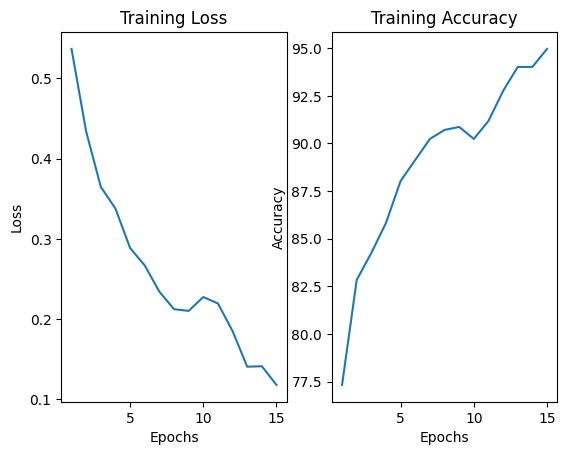

In [20]:
# Train and validate the model
num_epochs = 15
train_loss, train_accuracy = train_model(model, train_loader, criterion, optimizer, num_epochs)
validate_model(model, val_loader, criterion)

# Plotting the training loss and accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_loss)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracy)
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

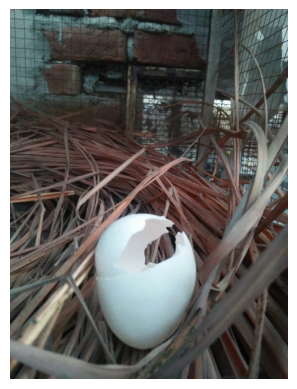

This is  damaged.


In [21]:
# Function to predict and display an image
def predict_image(image_path):
    # Load the image
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Transform and add batch dimension

    # Get the model's prediction
    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():
        output = model(image)
        prediction = 'damaged' if output.item() < 0.5 else 'not damaged'  # Thresholding at 0.5
    
    # Display the image and print the prediction
    plt.imshow(Image.open(image_path))
    plt.axis('off')  # Turn off axes for better visualization
    plt.show()
    print(f"This is  {prediction}.")
# Example usage: Change the path to the image you want to test
image_path = r'/Users/marienel18/Documents/ECDS-NeuralNets-main/Day 3/Datasets/testegg/damaged_1.jpg'
predict_image(image_path)

In [22]:
# Loop through all images in the 'test' folder
def predict_images_in_folder(folder_path):
    # Get all image file paths in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Check if the file is an image
            image_path = os.path.join(folder_path, filename)
            print(f"Predicting for {filename}...")
            predict_image(image_path)
            image_path = r'/Users/marienel18/Documents/ECDS-NeuralNets-main/Day 3/Datasets/testegg'

Predicting for damaged_2.jpg...


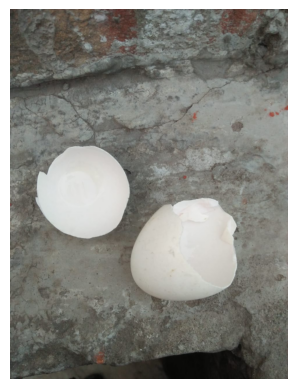

This is  damaged.
Predicting for damaged_3.jpg...


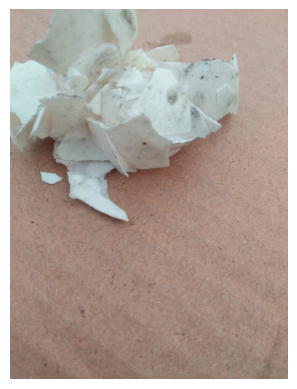

This is  damaged.
Predicting for damaged_1.jpg...


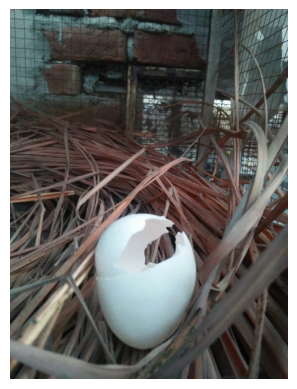

This is  damaged.
Predicting for damaged_4.jpg...


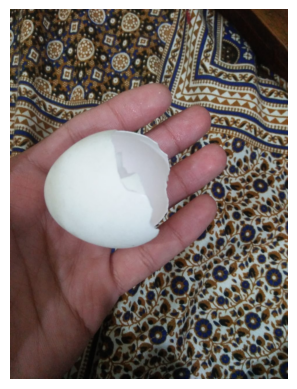

This is  not damaged.
Predicting for damaged_5.jpg...


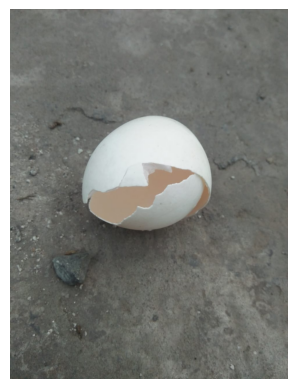

This is  damaged.
Predicting for not_damaged_2.jpg...


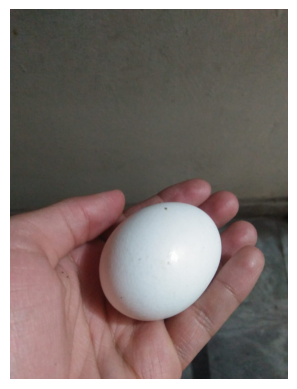

This is  not damaged.
Predicting for not_damaged_3.jpg...


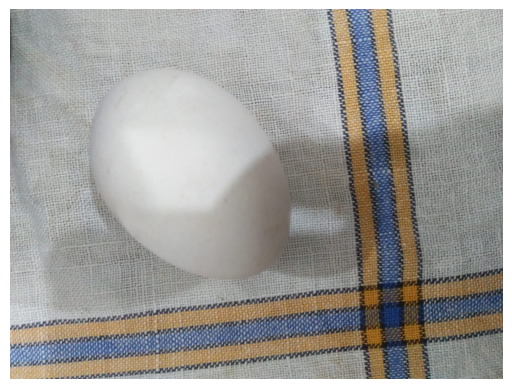

This is  not damaged.
Predicting for not_damaged_1.jpg...


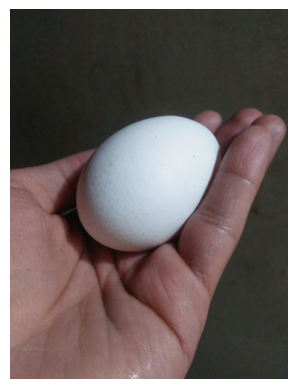

This is  not damaged.
Predicting for not_damaged_4.jpg...


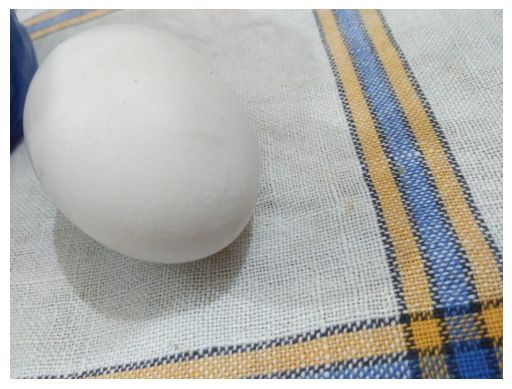

This is  not damaged.
Predicting for not_damaged_5.jpg...


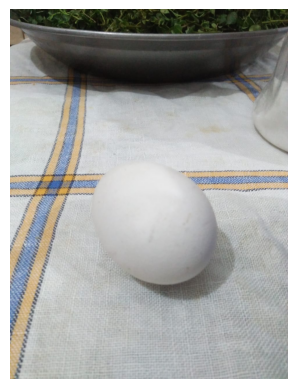

This is  not damaged.


In [23]:
# Example usage: Loop through all images in the test folder
folder_path = r'/Users/marienel18/Documents/ECDS-NeuralNets-main/Day 3/Datasets/testegg'
predict_images_in_folder(folder_path)